In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/AI-TAC"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import model.profile_performance as profile_performance
import aitac
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.stats
import tqdm
tqdm.tqdm_notebook(range(0))
from deeplift.dinuc_shuffle import dinuc_shuffle
import shap
from deeplift.visualization import viz_sequence

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Import model and data

In [2]:
model_path = "/users/amtseng/tfmodisco/data/processed/AI-TAC/data/AITAC.ckpt"
num_classes = 81
num_filters = 300
model = aitac.ConvNet(num_classes, num_filters)
model.load_state_dict(torch.load(model_path))

model.eval()
torch.set_grad_enabled(False)
model = model.cuda()

In [3]:
base_path = "/users/amtseng/tfmodisco/data/processed/AI-TAC/data/"
# Normalized peak heights for all cell types
cell_type_array = np.load(os.path.join(base_path, "cell_type_array.npy"))

# One-hot-encoded sequences: N x 4 x 251
one_hot_seqs = np.load(os.path.join(base_path, "one_hot_seqs.npy"))

# ID assigned to each peak (OCR), in the same order as above 2 files
peak_names = np.load(os.path.join(base_path, "peak_names.npy"))

# Chromosome of each peak in the same order as above files, to easily split data
chromosomes = np.load(os.path.join(base_path, "chromosomes.npy"))

# Names of each immune cell type in the same order as cell_type_array.npy, along
# with lineage designation of each cell type
cell_type_names = np.load(os.path.join(base_path, "cell_type_names.npy"), allow_pickle=True)

### Run data through model

In [4]:
batch_size = 100
num_samples = one_hot_seqs.shape[0]
predictions = np.empty((num_samples, num_classes))
activations = np.empty((num_samples, num_filters))
act_index = np.empty((num_samples, num_filters))

num_batches = int(np.ceil(num_samples / batch_size))
for i in tqdm.notebook.trange(num_batches):
    batch = one_hot_seqs[(i * batch_size) : ((i + 1) * batch_size)]
    pred, act, act_ind = model(torch.tensor(batch).cuda().float())
    predictions[(i * batch_size) : ((i + 1) * batch_size)] = pred.cpu().numpy()
    activations[(i * batch_size) : ((i + 1) * batch_size)] = act.cpu().numpy()
    act_index[(i * batch_size) : ((i + 1) * batch_size)] = act_ind.cpu().numpy()

In [5]:
pears = scipy.stats.pearsonr(np.ravel(predictions), np.ravel(cell_type_array))[0]
print("Pearson correlation of predictions to actual values: %f" % pears)

Pearson correlation of predictions to actual values: 0.293024


Text(0, 0.5, 'Number of examples')

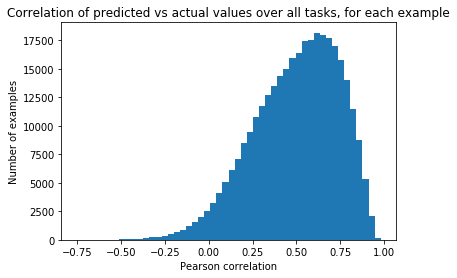

In [6]:
ind_corrs = profile_performance.pearson_corr(predictions, cell_type_array)
plt.figure()
plt.hist(ind_corrs, 50)
plt.title("Correlation of predicted vs actual values over all tasks, for each example")
plt.xlabel("Pearson correlation")
plt.ylabel("Number of examples")

In [44]:
np.where(ind_corrs > 0.75)

(array([    41,     52,     58, ..., 327893, 327899, 327910]),)

### Compute importance scores

In [7]:
def create_background(input_seq, input_length, bg_size=10, seed=20200127):
    """
    From a pair of single inputs to the model, generates the set of background
    inputs to perform interpretation against.
    Arguments:
        `input_seq`: a list of a single one-hot encoded input sequence of
            shape 4 x I
        `input_length`: length of input, I
        `bg_size`: the number of background examples to generate.
    Returns a single tensor in a list, where the tensor is G x 4 x I; these
    are the background inputs, which consists of random dinuceotide-shuffles
    of the original sequence.
    """
    input_seq_bg_shape = (bg_size, 4, input_length)
    if input_seq is None:
        # For DeepSHAP PyTorch, the model inputs could be None, but something
        # of the right shape still needs to be returned
        return [torch.zeros(input_seq_bg_shape).cuda().float()]
    else:
        input_seq_np = input_seq[0].cpu().numpy()
        input_seq_bg = np.empty(input_seq_bg_shape)
        rng = np.random.RandomState(seed)
        for i in range(bg_size):
            input_seq_shuf = dinuc_shuffle(np.transpose(input_seq_np), rng=rng)
            input_seq_bg[i] = np.transpose(input_seq_shuf)
        return [torch.tensor(input_seq_bg).cuda().float()]

In [8]:
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    """
    Computes the hypothetical contribution of any base in the input to the
    output, given the multipliers for the background data. This will simulate
    all possible base identities and compute a separate "difference-from-
    reference" for each, averaging the product of the multipliers with these
    differences, over the base identities. For the control profiles, the
    returned contribution is 0.
    Arguments:
        `mult`: multipliers for the background data: a G x 4 x I array
        `orig_inp`: the original target inputs to compute contributions for:
            a list of a 4 x I array
        `bg_data`: the background data: a G x 4 x I array
    Returns the set of importance scores as a list of a 4 x I array.
    Note that this rule is necessary because by default, the multipliers are
    multiplied by the difference-from-reference (for each reference in the
    background set). However, using the actual sequence as the target would not
    allow getting hypothetical scores, as the resulting attributions use a
    difference-from-reference wherever the target does _not_ have that base.
    Thus, we compute the hypothetical scores manually by trying every possible
    base as the target (instead of using the actual original target input).
    To back-out the actual scores for the original target input, simply extract
    the entries for the bases in the real input.
    """
    # Things were passed in as singleton lists
    input_mult, input_seq, input_seq_bg = mult[0], orig_inp[0], bg_data[0]
    
    # Allocate array to store hypothetical scores, one set for each background
    # reference
    input_seq_hyp_scores_eachref = np.empty_like(input_seq_bg)
    
    # Loop over input bases
    for i in range(input_seq.shape[0]):
        # Create hypothetical input of all one type of base
        hyp_input_seq = np.zeros_like(input_seq)
        hyp_input_seq[i, :] = 1

        # Compute difference from reference for each reference
        diff_from_ref = np.expand_dims(hyp_input_seq, axis=0) - input_seq_bg
        # Shape: G x 4 x I

        # Weight difference-from-reference by multipliers
        contrib = diff_from_ref * input_mult

        # Sum across bases axis; this computes the hypothetical score AS IF the
        # the target sequence were all that base
        input_seq_hyp_scores_eachref[:, i, :] = np.sum(contrib, axis=1)

    # Average hypothetical scores across background references
    input_seq_hyp_scores = np.mean(input_seq_hyp_scores_eachref, axis=0)
    return [input_seq_hyp_scores]

In [38]:
class WrapperModel(torch.nn.Module):
    def __init__(self, inner_model, task_index):
        """
        Takes an AI-TAC model and constructs wrapper model around it. This model
        takes in the same input (i.e. input tensor of shape B x 4 x I). The
        model will return an output of shape B x 1, which will be a single task's
        output, or all outputs summed.
        Arguments:
            `inner_model`: an instantiated or loaded model from
                `profile_model.profile_tf_binding_predictor`
            `task_index`: a specific task index (0-indexed) to perform
                explanations from (i.e. explanations will only be from the
                specified outputs); by default explains all tasks
        """
        super().__init__()
        self.inner_model = inner_model
        self.task_index = task_index
        
    def forward(self, input_seqs):
        predictions, _, _ = self.inner_model(input_seqs)  # Shape: B x T
        
        # Standard-deviation-normalize the vectors
        std = torch.std(predictions, dim=1, keepdim=True)  # Standard deviation, but don't explain them
        normed = predictions / std  # Shape: B x T
        
        if self.task_index:
            return normed[:, self.task_index : (self.task_index + 1)]
        else:
            return torch.sum(normed, dim=1, keepdim=True)

In [10]:
def create_explainer(model, input_length, bg_size=10, task_index=None):
    """
    Given a trained PyTorch model, creates a Shap DeepExplainer that returns
    hypothetical scores for the input sequence.
    Arguments:
        `model`: a model from `aitac` to explain
        `input_length`: length of input, I
        `bg_size`: the number of background examples to generate.
        `task_index`: a specific task index (0-indexed) to perform explanations
            from (i.e. explanations will only be from the specified outputs); by
            default explains all tasks
    Returns a function that takes in input sequences, and outputs hypothetical
    scores for the input sequences.
    """
    wrapper_model = WrapperModel(model, task_index)
    
    bg_func = lambda input_seq: create_background(
        input_seq, input_length, bg_size=bg_size, seed=None
    )

    explainer = shap.DeepExplainer(
        model=wrapper_model,
        data=bg_func,
        combine_mult_and_diffref=combine_mult_and_diffref
    )

    def explain_fn(input_seqs):
        """
        Given input sequences and control profiles, returns hypothetical scores
        for the input sequences.
        Arguments:
            `input_seqs`: a B x I x 4 array
            `cont_profs`: a B x T x O x 4 array
        Returns a B x I x 4 array containing hypothetical importance scores for
        each of the B input sequences.
        """
        # Convert to tensors
        input_seqs_t = torch.tensor(input_seqs).cuda().float()

        return explainer.shap_values(
            [input_seqs_t], progress_message=None
        )[0]

    return explain_fn

In [39]:
# Compute importance scores
task_index = None  # Explain all tasks in aggregate

torch.set_grad_enabled(True)
input_length = one_hot_seqs.shape[2]

explainer = create_explainer(model, input_length, task_index=task_index)

hyp_scores = np.empty_like(one_hot_seqs)

for i in tqdm.notebook.trange(num_batches):
    batch = one_hot_seqs[(i * batch_size) : ((i + 1) * batch_size)]
    hyp_scores[(i * batch_size) : ((i + 1) * batch_size)] = explainer(batch)
    if i == 0:
        break

act_scores = hyp_scores * one_hot_seqs

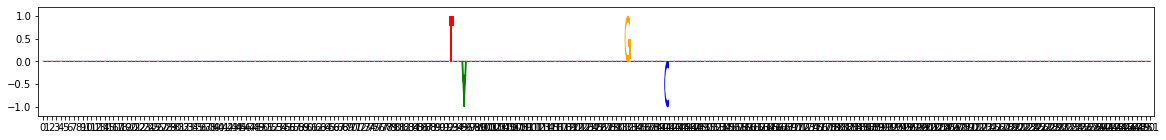

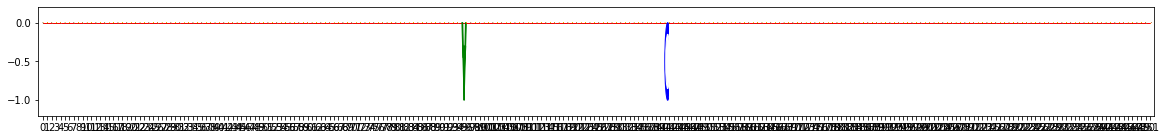

In [45]:
viz_sequence.plot_weights(np.transpose(hyp_scores[41]))
viz_sequence.plot_weights(np.transpose(act_scores[41]))